Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [2]:
df = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
df.head()

Quarter        Sales
0   Q1_86  1734.827000
1   Q2_86  2244.960999
2   Q3_86  2533.804993
3   Q4_86  2154.962997
4   Q1_87  1547.818996

### Data Exploration

In [3]:
df.shape

(42, 2)

In [4]:
df.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [5]:
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

In [6]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [7]:
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [9]:
df[df.duplicated()].shape

(0, 2)

In [10]:
df.describe()

Sales
count    42.000000
mean   2994.353308
std     977.930896
min    1547.818996
25%    2159.714247
50%    2782.376999
75%    3609.250000
max    5253.000000

In [11]:
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
df.head()

Quarter        Sales Quarter_Year
0   Q1_86  1734.827000      Q1 1986
1   Q2_86  2244.960999      Q2 1986
2   Q3_86  2533.804993      Q3 1986
3   Q4_86  2154.962997      Q4 1986
4   Q1_87  1547.818996      Q1 1987

In [12]:
df['Date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
df.head()

Quarter        Sales Quarter_Year       Date
0   Q1_86  1734.827000      Q1 1986 1986-01-01
1   Q2_86  2244.960999      Q2 1986 1986-04-01
2   Q3_86  2533.804993      Q3 1986 1986-07-01
3   Q4_86  2154.962997      Q4 1986 1986-10-01
4   Q1_87  1547.818996      Q1 1987 1987-01-01

In [13]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head()

/var/folders/bp/xcn4mbr53tscnw24mpsq4m0m0000gn/T/ipykernel_48746/1652600336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Quarters'][i] = n[0:2]


Quarter        Sales Quarter_Year       Date Quarters
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1

In [14]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

Quarter        Sales Quarter_Year       Date Quarters  Q1  Q2  Q3  Q4
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   1   0   0   0
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   0   1   0   0
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   0   0   1   0
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   0   0   0   1
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   1   0   0   0

In [15]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

Sales       Date Quarters  Q1  Q2  Q3  Q4
0  1734.827000 1986-01-01       Q1   1   0   0   0
1  2244.960999 1986-04-01       Q2   0   1   0   0
2  2533.804993 1986-07-01       Q3   0   0   1   0
3  2154.962997 1986-10-01       Q4   0   0   0   1
4  1547.818996 1987-01-01       Q1   1   0   0   0

In [16]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [17]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head()

Quarter        Sales Quarter_Year       Date Quarters month  year
0   Q1_86  1734.827000      Q1 1986 1986-01-01       Q1   Jan  1986
1   Q2_86  2244.960999      Q2 1986 1986-04-01       Q2   Apr  1986
2   Q3_86  2533.804993      Q3 1986 1986-07-01       Q3   Jul  1986
3   Q4_86  2154.962997      Q4 1986 1986-10-01       Q4   Oct  1986
4   Q1_87  1547.818996      Q1 1987 1987-01-01       Q1   Jan  1987

<Axes: xlabel='month', ylabel='year'>

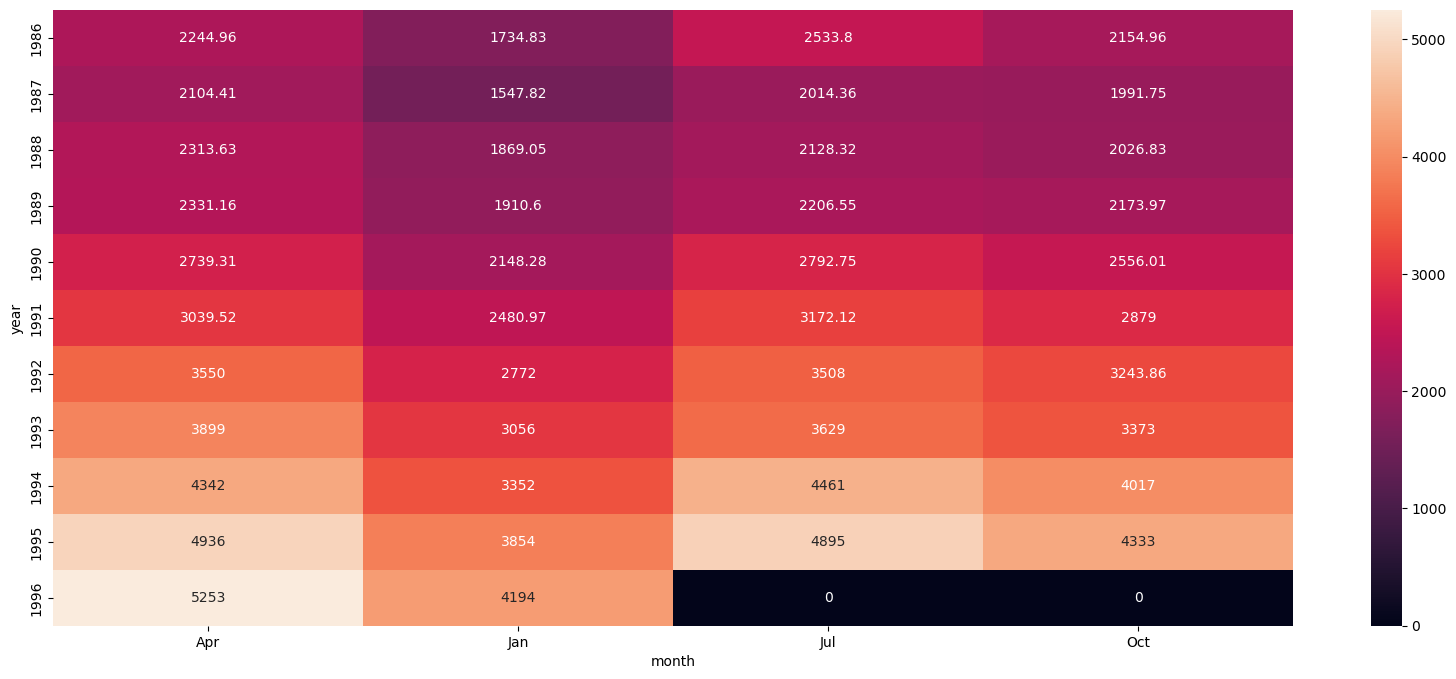

In [18]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=df,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

The plot shows the sales corresponding to each quarter in every year. Columns correspond to quarters and rows correspond to years

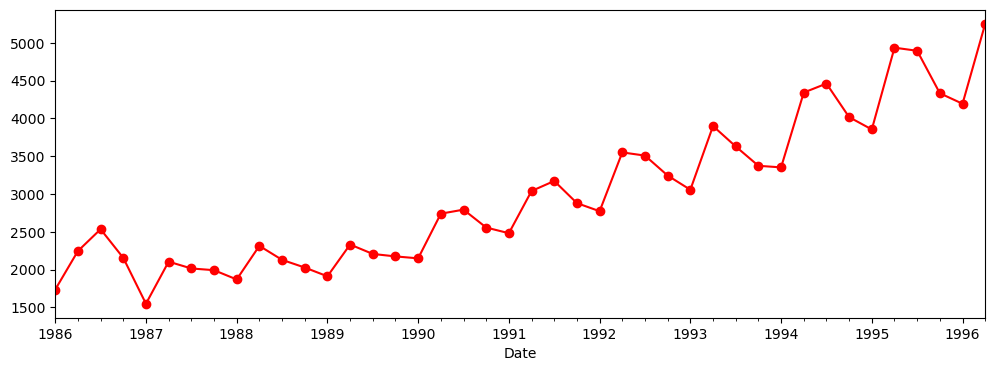

In [19]:
df1['Sales'].plot(figsize=(12, 4),color='red',marker='o')
plt.show()

Due to uptrend, we can say that the data is not stationary. Also, the variance with respect to time also seems to vary.

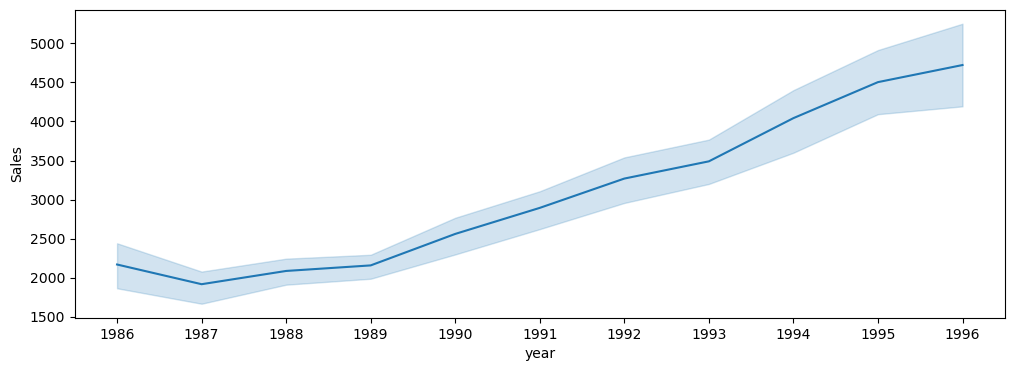

In [98]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
warnings.filterwarnings("ignore")

##### Lag plot

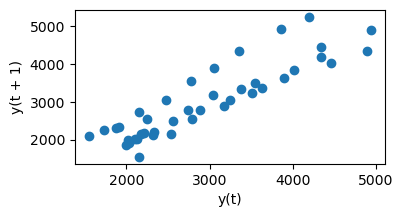

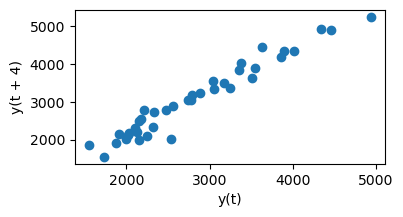

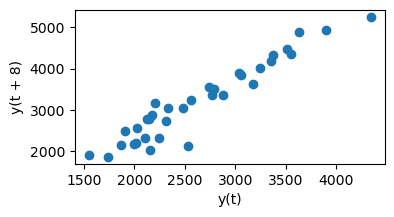

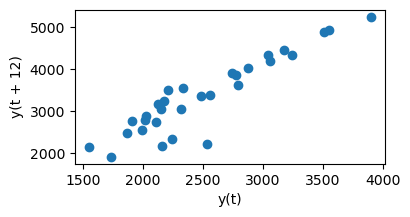

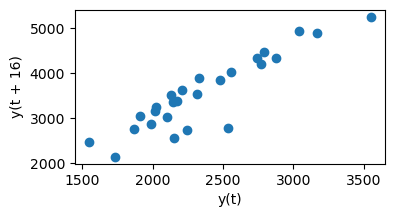

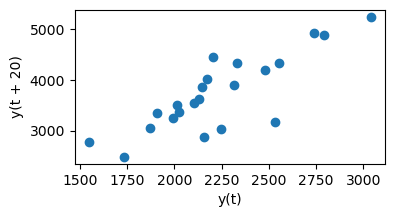

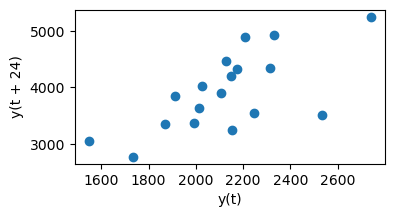

In [22]:
for i in [1, 4, 8, 12, 16, 20, 24]:
    plt.figure(figsize=(4,2))
    lag_plot(df.Sales, lag=i)
    plt.show()

#### Moving average plot

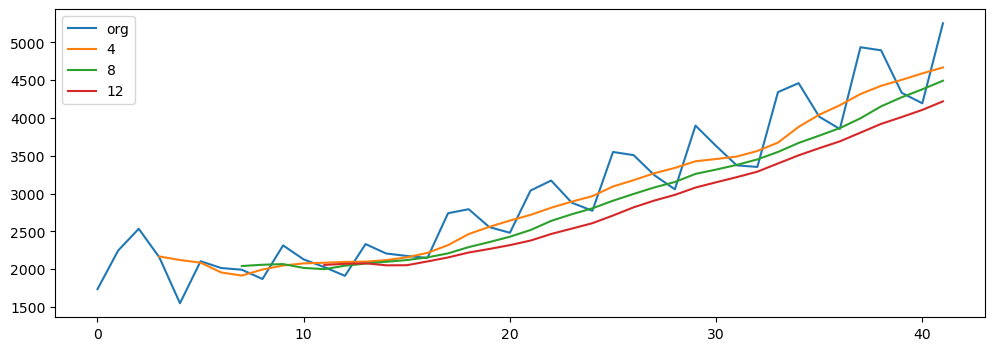

In [23]:
plt.figure(figsize=(12,4))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

The plot shows the moving average for different number of elements considered including the original dataset. Uptrend is visible in the plot.

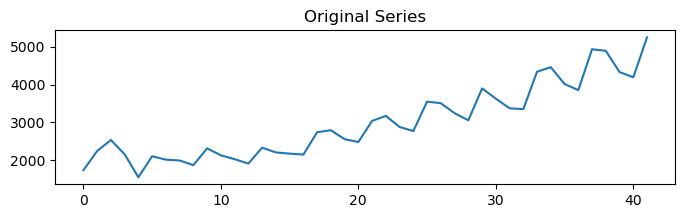

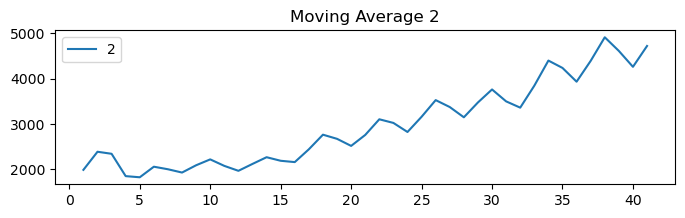

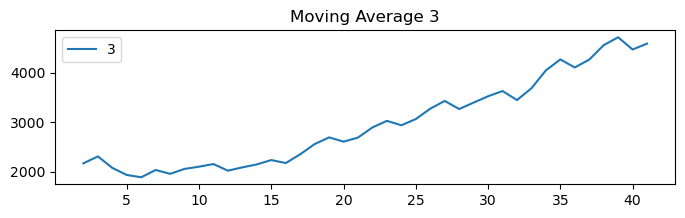

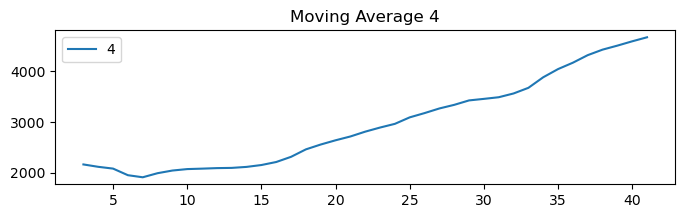

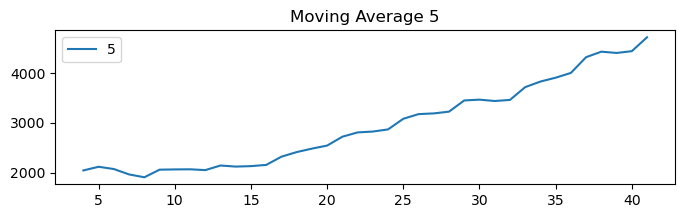

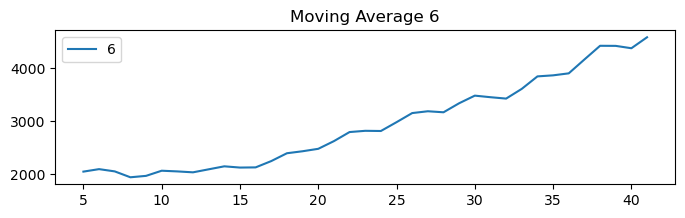

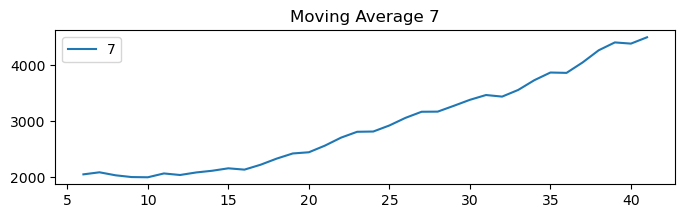

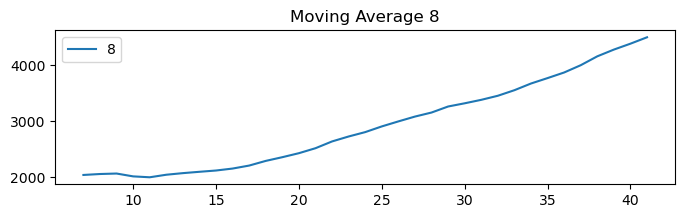

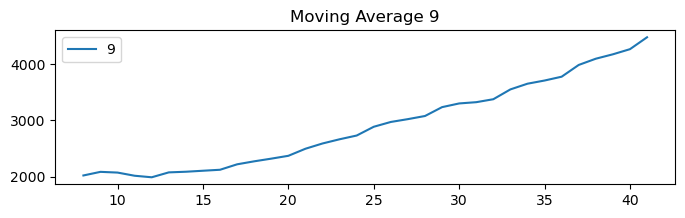

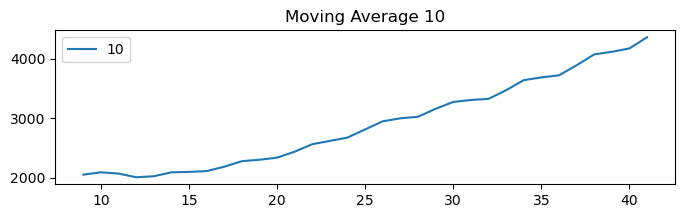

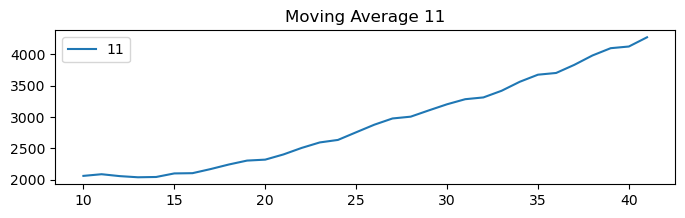

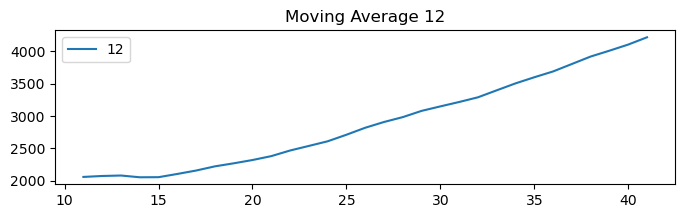

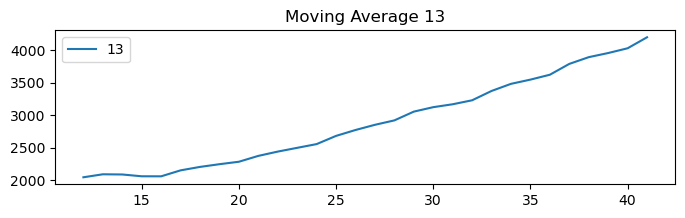

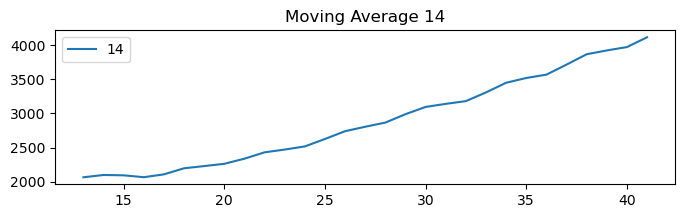

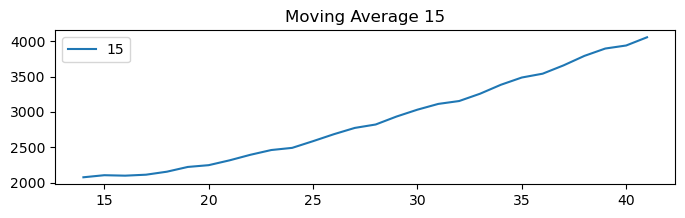

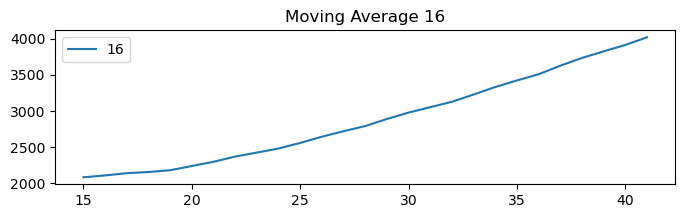

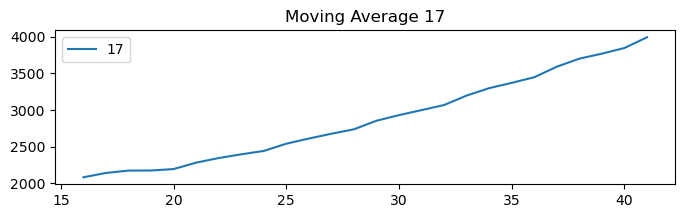

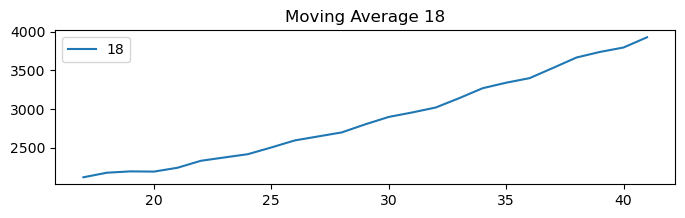

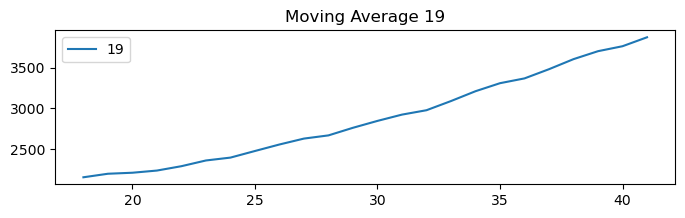

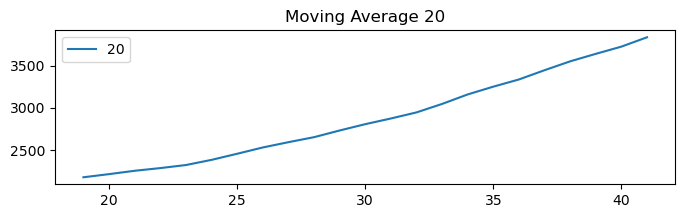

In [24]:
plt.figure(figsize=(8,2))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,21):
    plt.figure(figsize=(8,2))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

Moving averages for different number of elements considered for averaging are plotted. The moving average with multiple of 4 shows the smoothest plots (Moving average 4,8,12, 16, 20)

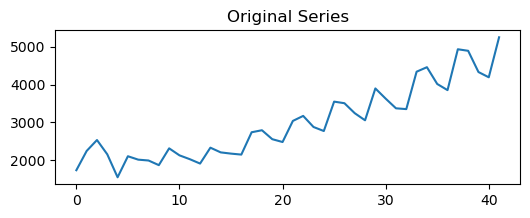

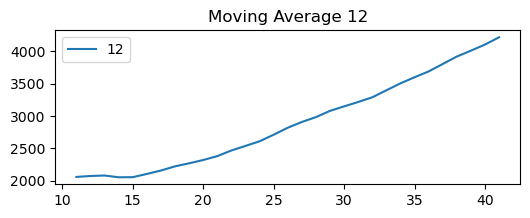

In [25]:
plt.figure(figsize=(6,2))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(6,2))
df["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

Two plots from above set of plots are separated out to see the difference.

#### Time series decomposition plot

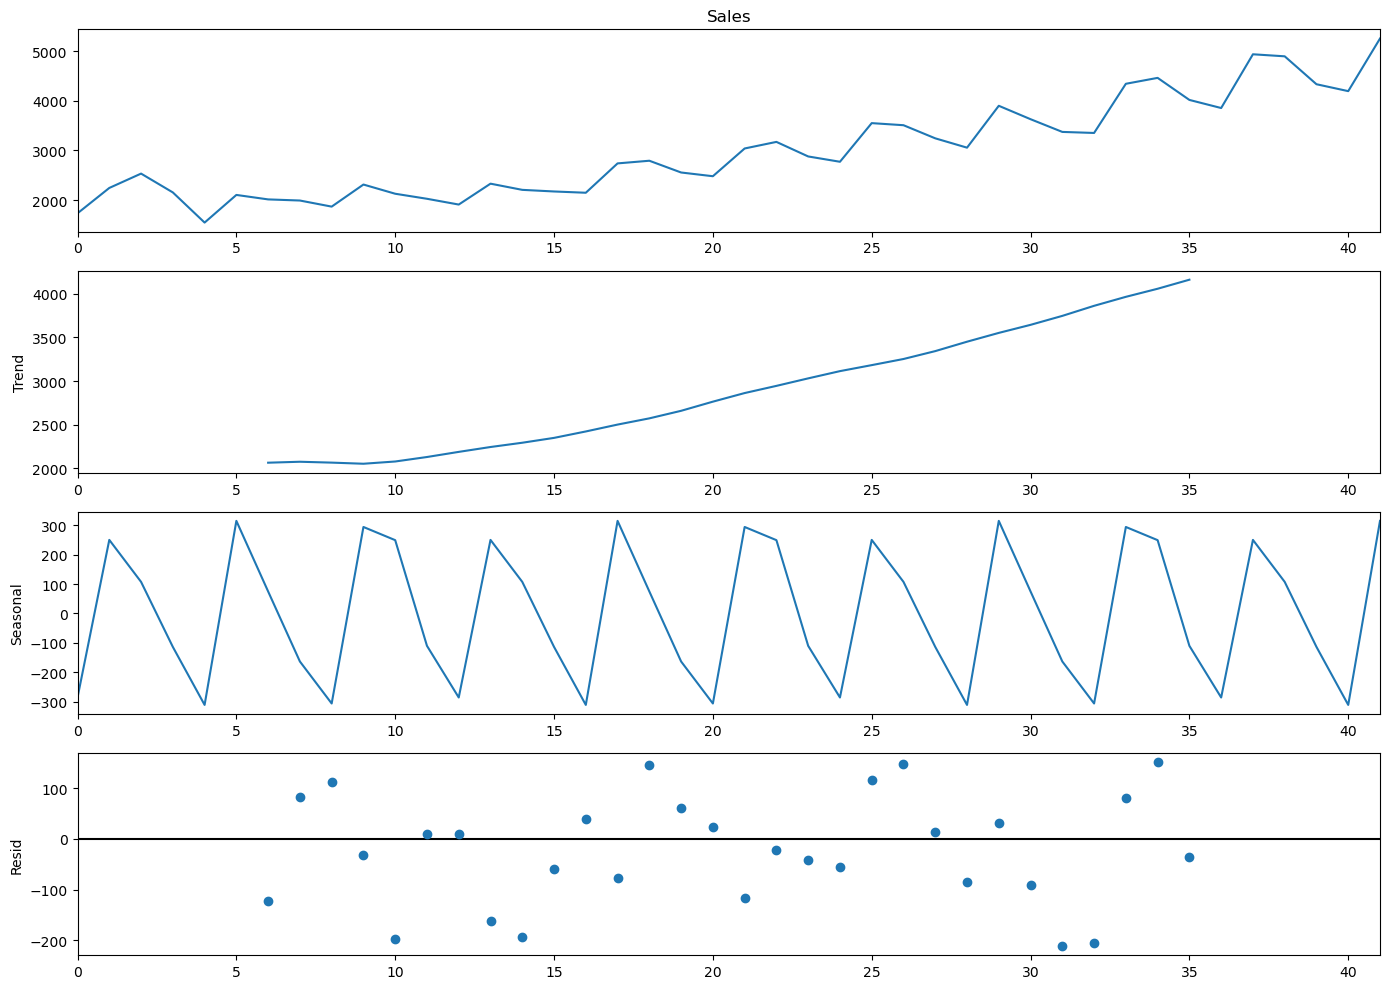

In [26]:
decompose_ts_add = seasonal_decompose(df.Sales,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

The last three plots shows the trend component, seasonality component and the noise compoent.

#### ACF and PACF plots

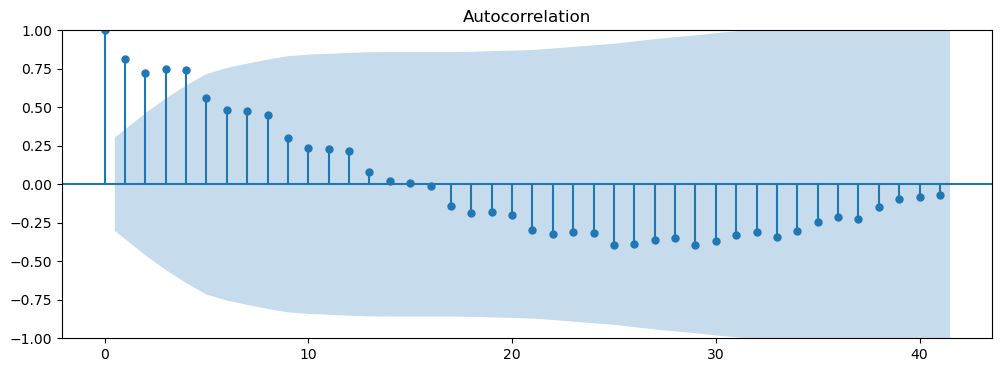

In [27]:
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Sales,lags=41)
    plt.show()

The ACF plot shows that the autocorrelation is acceptable from lag-5

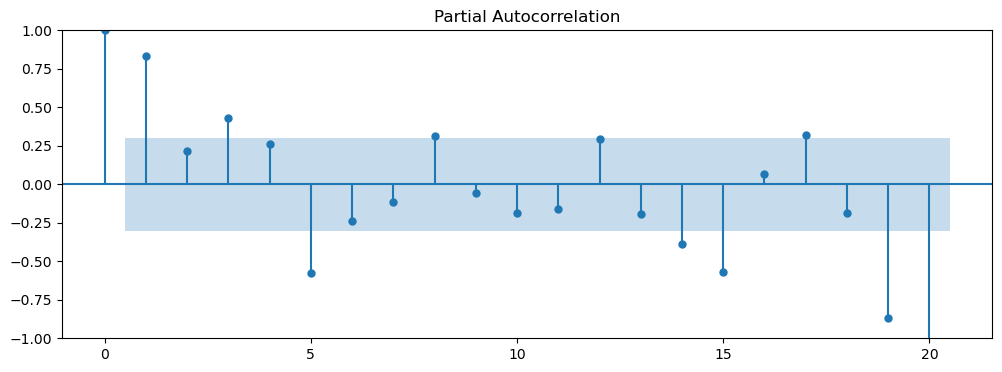

In [28]:
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

The partial autocorrelation function captures the correlation between time series and a lagged version of itself.

In [29]:
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head())

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330


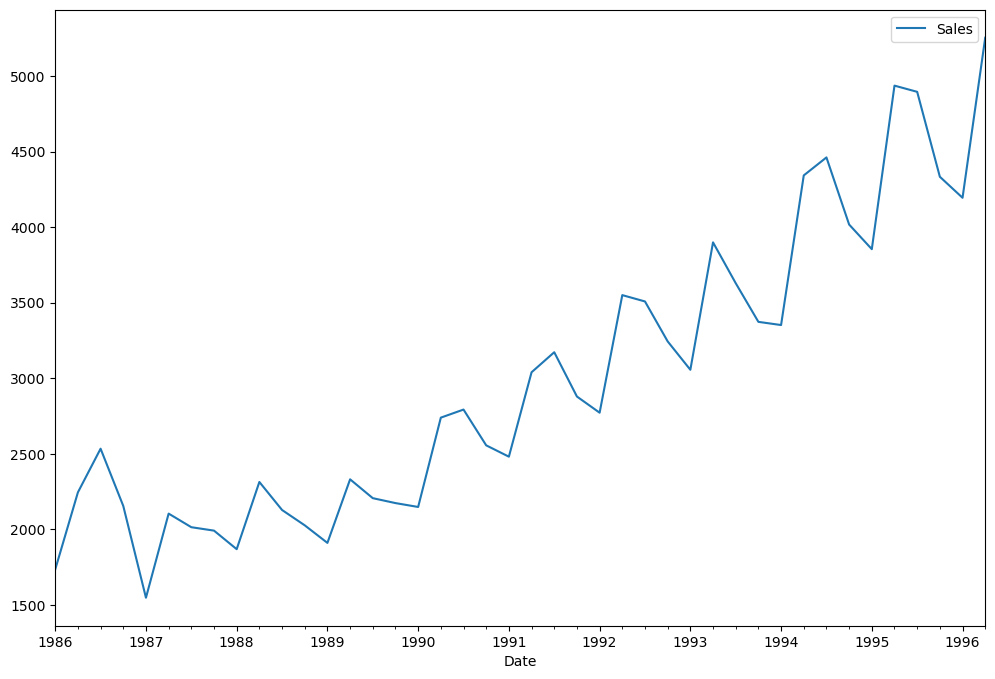

In [30]:
interpolated_month = upsampled_month.interpolate(method='linear') ## interplation was done for nan values which we get after doing upsampling by month
print(interpolated_month.head())
interpolated_month.plot(figsize=(12,8))
plt.show()

In [31]:
interpolated_month

Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
...                 ...
1995-12-31  4240.333333
1996-01-31  4194.000000
1996-02-29  4547.000000
1996-03-31  4900.000000
1996-04-30  5253.000000

[124 rows x 1 columns]

### Time series decomposition

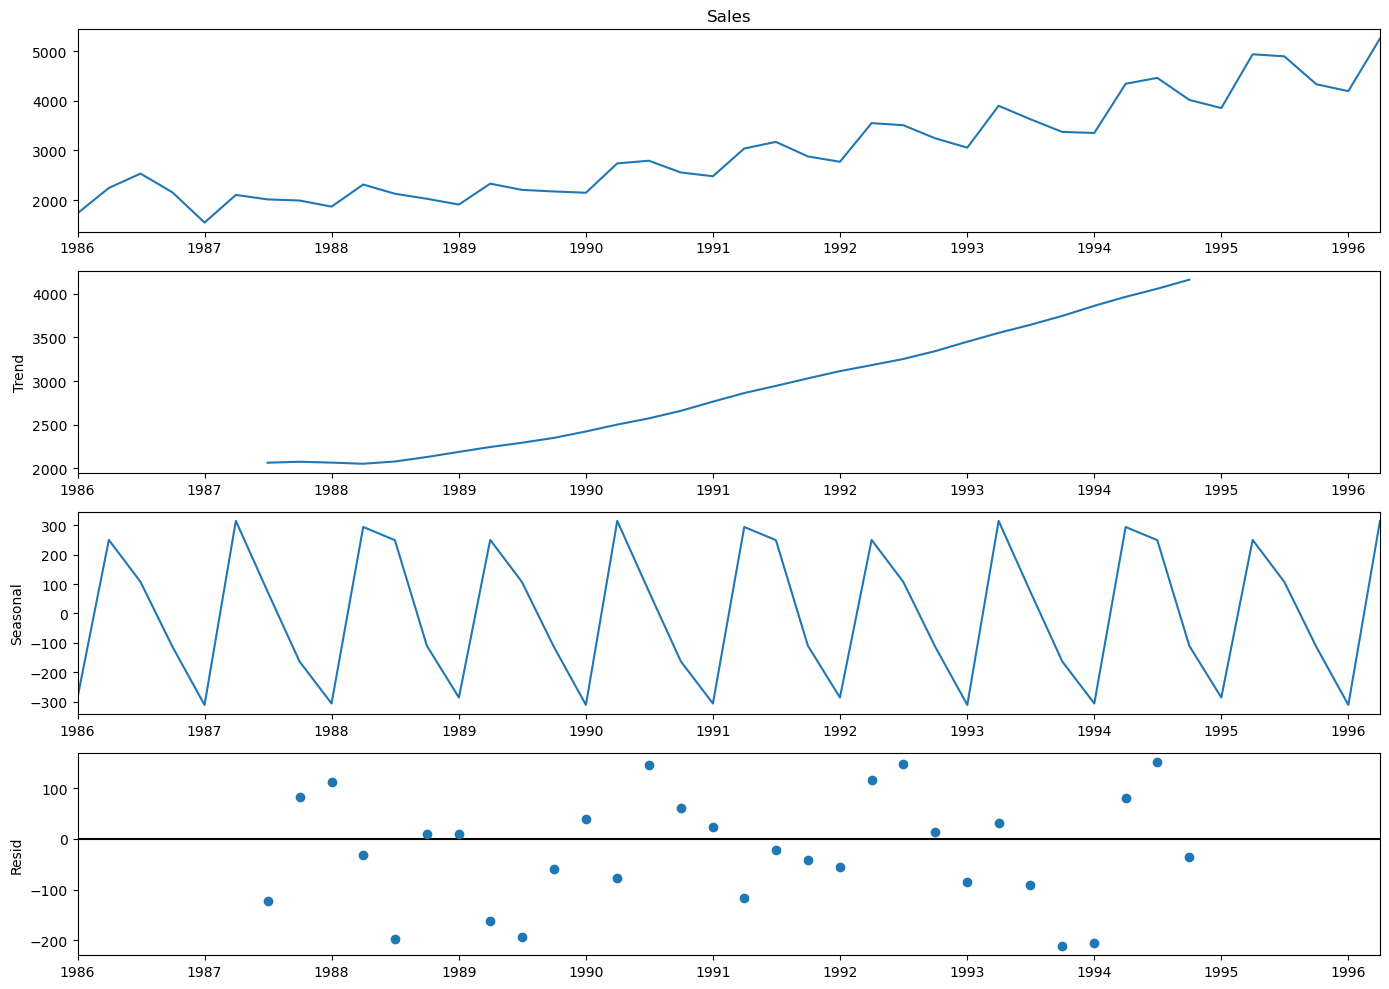

In [32]:
decompose_ts_add = seasonal_decompose(df1.Sales,period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

The decomposition into trend, seasonality and noise components show that there is uptrend in the plot, yearly seasonality and random noise present. If the bottom three plots are added together, we can get the first plot.

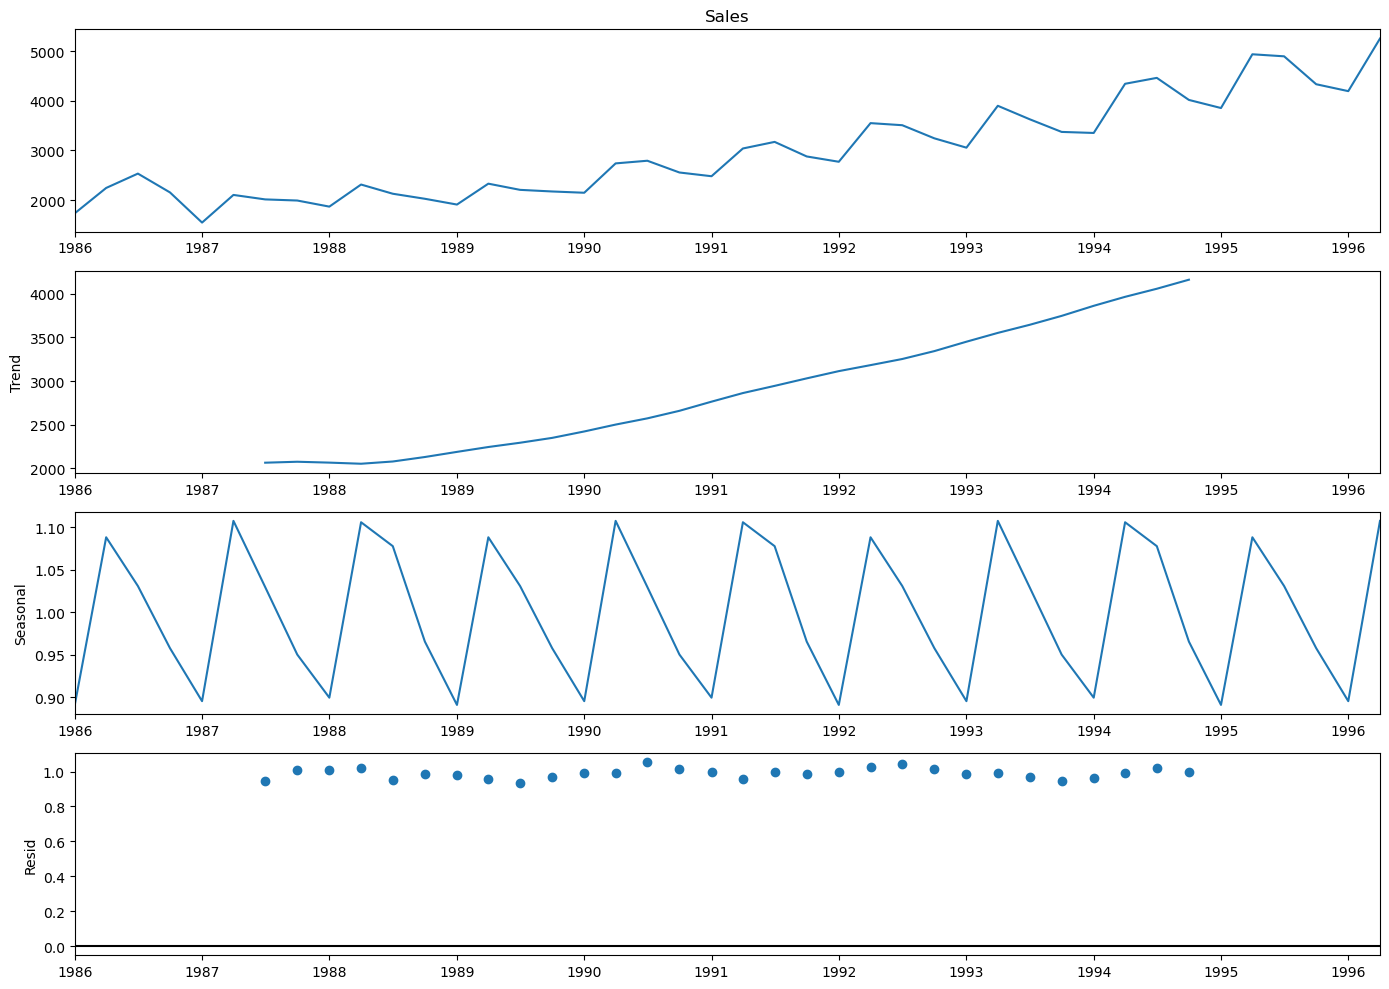

In [33]:
decompose_ts_add = seasonal_decompose(df1.Sales,period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

The decomposition into trend, seasonality and noise components show that there is uptrend in the plot, yearly seasonality and random noise present. If the bottom three plots are mulitplied together, we can get the first plot.

In [34]:
df1.shape

(42, 6)

In [35]:
size = 100
train_data = interpolated_month[:size]
test_data = interpolated_month[size:]

In [36]:
print('Train:',train_data.index.min(),train_data.index.max(),'\n',
'Test:',test_data.index.min(),test_data.index.max())

Train: 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test: 1994-05-31 00:00:00 1996-04-30 00:00:00


<Axes: title={'center': 'Test'}, xlabel='Date'>

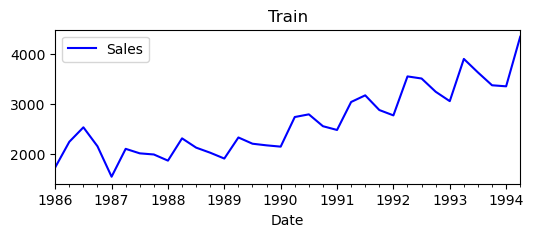

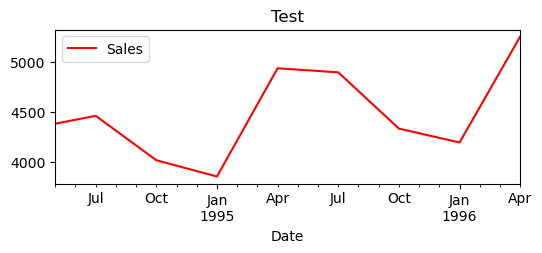

In [37]:
train_data.plot(title = "Train", figsize=(6,2),color='blue')
test_data.plot(title = "Test", figsize=(6,2),color='red')

#### Testing different methods and finding the RMSE with respect to each method

In [38]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

In [39]:
warnings.filterwarnings("ignore")

# Simple Exponential method
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = np.sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = np.sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)

# Holt method / Double exponential
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = np.sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = np.sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)

# Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = np.sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = np.sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)

# Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = np.sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = np.sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)

# Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = np.sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = np.sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)

# Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = np.sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = np.sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)

In [40]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_ad","Triple_Exp_mul_ad","Triple_Exp_ad_mul"\
                                  ,"Triple_Exp_mul"]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  Triple_Exp_mul_ad   50.223974      1.487269         78.733258
1     Triple_Exp_mul   49.439105      1.807823        101.651349
2  Triple_Exp_ad_mul  165.781044      5.168784        270.084791
3         Simple_Exp  129.379526      6.619719        381.954224
4      Triple_Exp_ad   44.265365     35.695713       1828.476772
5         Double_Exp  106.049183     89.494625       4549.907951

The RMSE and MAPE values obtained for different models are compared here. Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential) gives the least RMSE and MAPE.

However, RMSE from Train data is least for Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential). But, the RMSE for test and train set is very different indicating the possibility of overfitting. Hence, this method is not preferred.


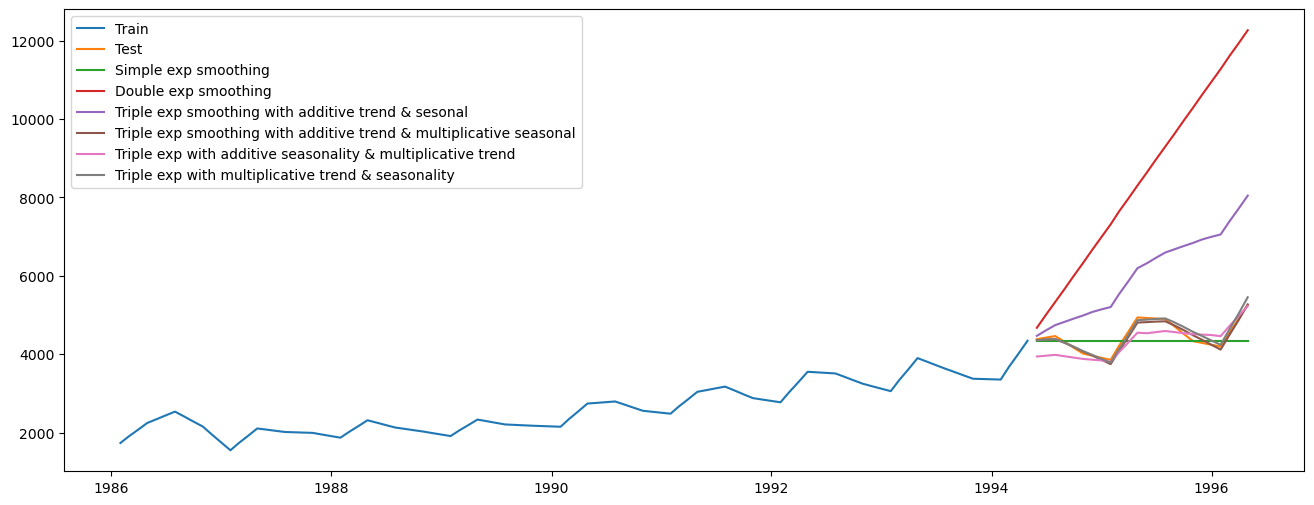

In [41]:
plt.figure(figsize=(16,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exp smoothing')
plt.plot(test_pred_dexp, label='Double exp smoothing')
plt.plot(test_pred_ad_texp, label='Triple exp smoothing with additive trend & sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exp smoothing with additive trend & multiplicative seasonal')
plt.plot(test_pred_ad_mul_texp, label='Triple exp with additive seasonality & multiplicative trend')
plt.plot(test_pred_mul_texp, label='Triple exp with multiplicative trend & seasonality')
plt.legend(loc='best')
plt.show()

The plots obtained after prediction after applying the methods are shown here. As can be seen in the dataframe above, the triple exponential smoothing with additive trend and multiplicative seasonality gives the best fit.

## ARIMA

Test of stationarity

In [42]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(dfoutput)

In [43]:
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
dtype: float64


Since p-value is 0.9968 > 0.05, this means we have to accept null hypothesis. So, data is non stationary

##### Square root transformation

In [44]:
square_root= pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

In [45]:
test_stationarity(square_root)

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

##### Log transform

In [46]:
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

In [47]:
test_stationarity(log)

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

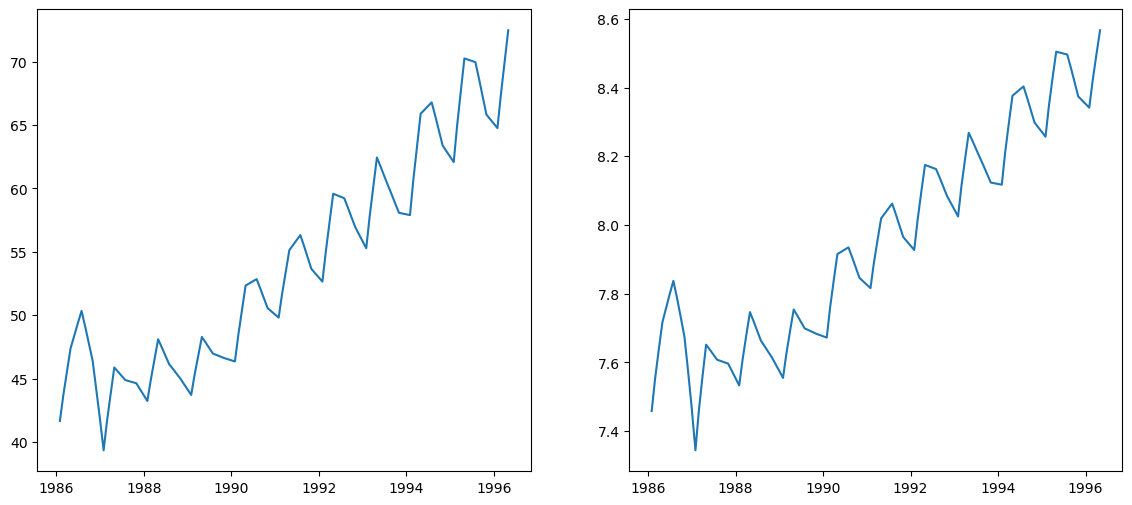

In [48]:
fig=plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(square_root['Sales'], label='square root transformation')

plt.subplot(1,2,2)
plt.plot(log['Sales'], label='log transformation')

plt.show()

#### Conversion of non-stationary to stationary dataset

##### Box cox transformation

Sales
Date                
1986-01-31  7.458663
1986-02-28  7.552170
1986-03-31  7.637676
1986-04-30  7.716443
1986-05-31  7.758437

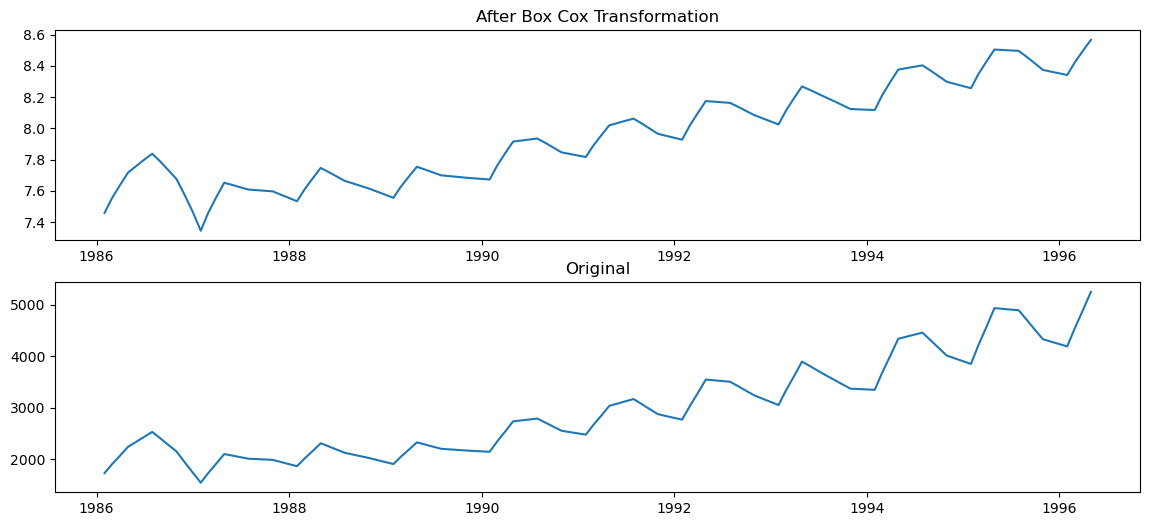

In [56]:
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

In [57]:
test_stationarity(data_boxcox)

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
dtype: float64


Null hypothesis rejected. => Non-stationary

##### Differencing box cox transformation

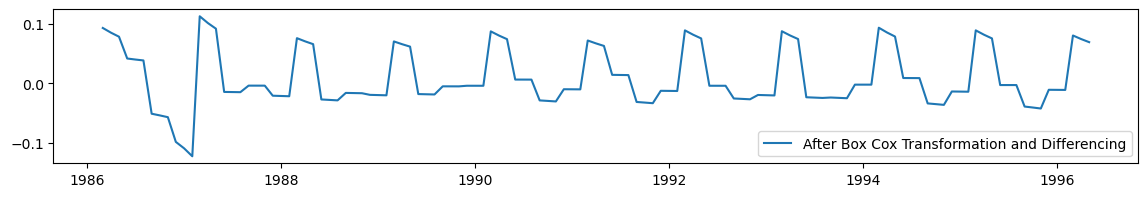

In [58]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(14,2))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

In [59]:
test_stationarity(data_boxcox_diff)

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
dtype: float64


Null hypothesis accepted. => Stationary

Hence, we can apply differencing boxcox model for the predictions.

In [60]:
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [61]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [62]:
from numpy import sqrt

In [63]:
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(data_boxcox_diff.Sales, p_values, d_values, q_values)

Best ARIMA(4, 0, 4) RMSE=0.025


The best ARIMA model is obtained when we have p=4, d=0, and q=4. In this model, the RMSE value obtained is 0.025

In [64]:
train_data_boxcox = data_boxcox[:size]
test_data_boxcox = data_boxcox[size:]
train_data_boxcox_diff = data_boxcox_diff[:(size-1)]
test_data_boxcox_diff = data_boxcox_diff[(size-1):]

In [65]:
model = ARIMA(train_data_boxcox_diff, order=(4, 0, 4))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Sales[0])
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

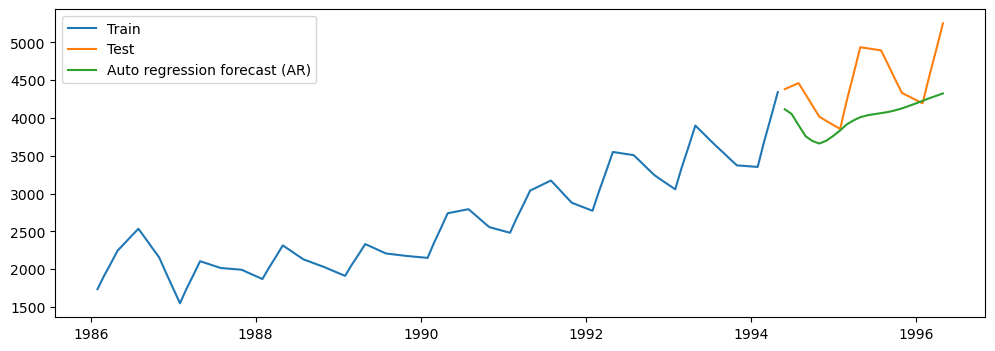

In [66]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

In [67]:
rmse_ARIMA = np.sqrt(mean_squared_error(test_data, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_ARIMA

530.13

In [68]:
model_residual = model_fit.resid
model_residual.mean()

0.0004714177833086247

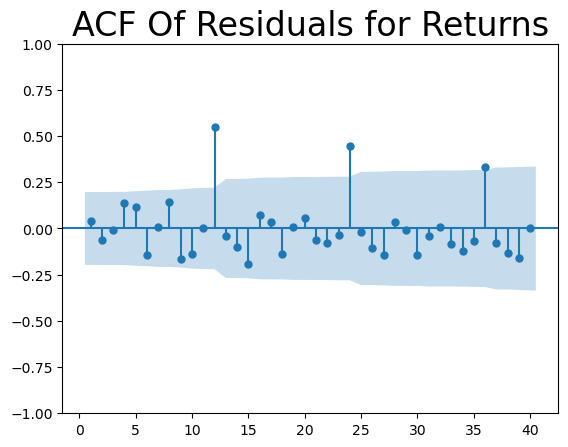

In [69]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

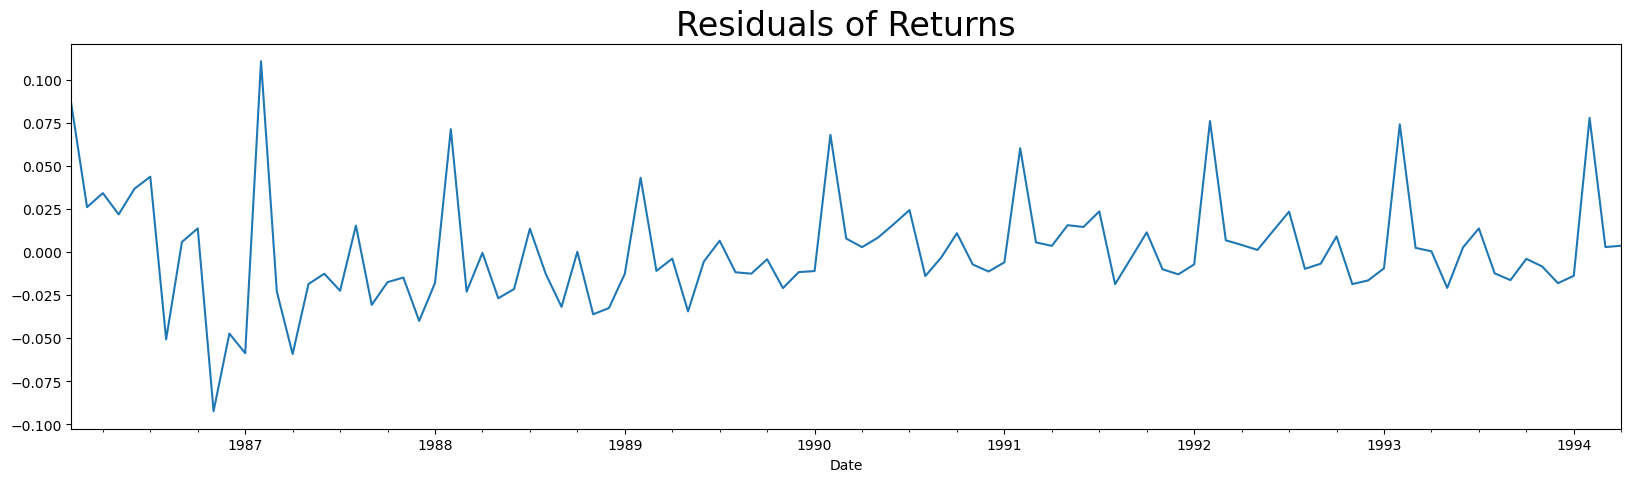

In [70]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

###### Arima on original data without upsampling

In [71]:
size = int(np.round(len(df1)*0.70,))

cocacola_train = df1.Sales[:size]
cocacola_validation = df1.Sales[size:]
print('Dataset %d, Validation %d' % (len(cocacola_train), len(cocacola_validation)))
cocacola_train.to_csv('cocacola_train.csv', header=False)
cocacola_validation.to_csv('cocacola_validation.csv', header=False)

Dataset 29, Validation 13


In [72]:
print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))
train_data.to_csv('cocacola_train.csv', header=False)
test_data.to_csv('cocacola_validation.csv', header=False)

Dataset 100, Validation 24


In [73]:
# load dataset
train = pd.read_csv('cocacola_train.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
train = train.astype('int64')
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5)
q_values = range(0, 5)
evaluate_models(train.values, p_values, d_values, q_values)

LU decomposition error.
Best ARIMA(4, 1, 4) RMSE=83.912


In [74]:
# separate out a validation dataset
size = int(np.round(len(cocacola_train)*0.70,))

train_data = cocacola_train[:size]
test_data = cocacola_train[size:]
print('Dataset %d, Validation %d' % (len(train_data), len(test_data)))

Dataset 20, Validation 9


In [75]:
model = ARIMA(train_data,order=(4, 0, 4))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   20
Model:                 ARIMA(4, 0, 4)   Log Likelihood                -159.004
Date:                Wed, 23 Aug 2023   AIC                            338.007
Time:                        13:03:53   BIC                            347.965
Sample:                    01-01-1986   HQIC                           339.951
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2176.2175   6.72e-07   3.24e+09      0.000    2176.218    2176.218
ar.L1          0.0449      0.081      0.553      0.581      -0.114       0.204
ar.L2         -0.0002      0.000     -0.584      0.559      -0.001       0.000
ar.L3         -0.0454      0.081     -0.558      0.577      -0.205       0.114
ar.L4          0.9998      0.000   2369.523      0.000       0.999       1.001
ma.L1          0.9609      0.094     10.269      0.000       0.777       1.144
ma.L2         -0.0688      0.116     -0.595      0.552      -0.295       0.158
ma.L3          0.9602      0.094     10.257      0.000       0.777       1.144
ma.L4          0.9997      0.210      4.761      0.000       0.588       1.411
sigma2      8459.2529   3.41e-05   2.48e+08      0.000    8459.253    8459.253
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                 0.45
Prob(Q):                              0.39   Prob(JB):                         0.80
Heteroskedasticity (H):               1.86   Skew:                            -0.28
Prob(H) (two-sided):                  0.43   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.97e+23. Standard errors may be unstable.
"""

In [76]:
# Obtain predicted values
start=len(train_data)
end=len(cocacola_train)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')
predictions = predictions.rename('ARIMA(0,1,2) Predictions')

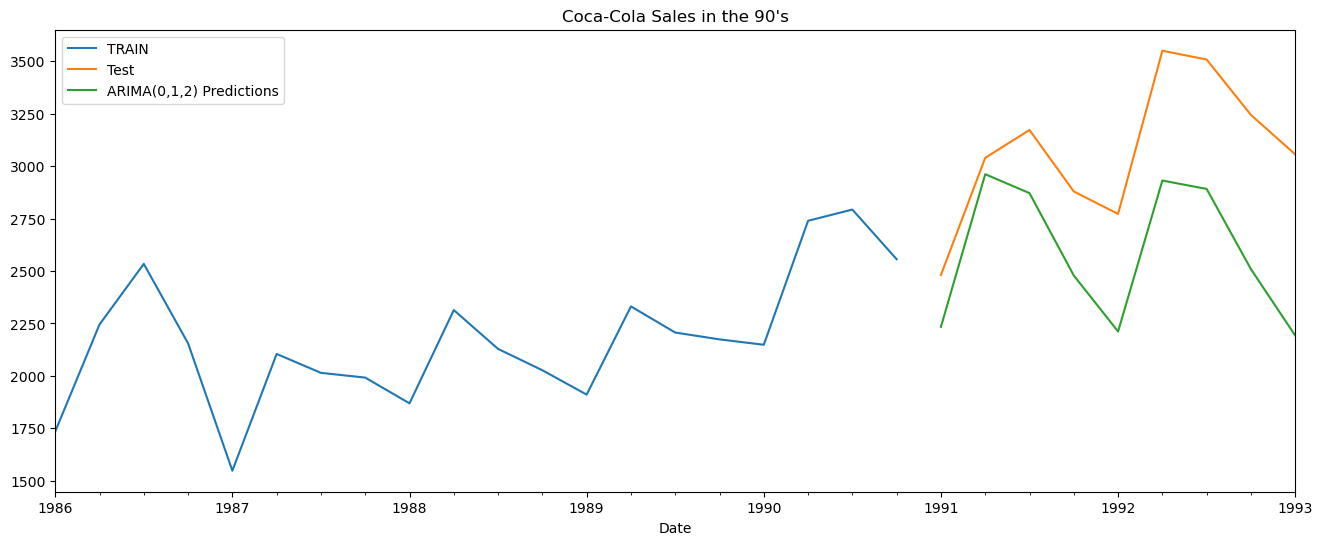

In [77]:
title = "Coca-Cola Sales in the 90's"
ylabel='Sales'
xlabel='' 

train_data.plot(legend=True,label='TRAIN' ,figsize=(16,6),title=title)
test_data.plot(legend=True,label='Test',figsize=(16,6),title=title)
predictions.plot(legend=True)
plt.show()

In [78]:
from statsmodels.tools.eval_measures import rmse

rmse_arima = rmse(test_data, predictions)
rmse_arima.round(2)

545.97

In [80]:
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

Date        Sales    t  t_squared month  year  Jan  Feb  Mar  Apr  \
0   1986-01-31  1734.827000    1          1   Jan  1986    1    0    0    0   
1   1986-02-28  1904.871666    2          4   Feb  1986    0    1    0    0   
2   1986-03-31  2074.916332    3          9   Mar  1986    0    0    1    0   
3   1986-04-30  2244.960999    4         16   Apr  1986    0    0    0    1   
4   1986-05-31  2341.242330    5         25   May  1986    0    0    0    0   
..         ...          ...  ...        ...   ...   ...  ...  ...  ...  ...   
119 1995-12-31  4240.333333  120      14400   Dec  1995    0    0    0    0   
120 1996-01-31  4194.000000  121      14641   Jan  1996    1    0    0    0   
121 1996-02-29  4547.000000  122      14884   Feb  1996    0    1    0    0   
122 1996-03-31  4900.000000  123      15129   Mar  1996    0    0    1    0   
123 1996-04-30  5253.000000  124      15376   Apr  1996    0    0    0    1   

     May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_sales  
0      0    0    0    0    0    0    0    0   7.458663  
1      0    0    0    0    0    0    0    0   7.552170  
2      0    0    0    0    0    0    0    0   7.637676  
3      0    0    0    0    0    0    0    0   7.716443  
4      1    0    0    0    0    0    0    0   7.758437  
..   ...  ...  ...  ...  ...  ...  ...  ...        ...  
119    0    0    0    0    0    0    0    1   8.352397  
120    0    0    0    0    0    0    0    0   8.341410  
121    0    0    0    0    0    0    0    0   8.422223  
122    0    0    0    0    0    0    0    0   8.496990  
123    0    0    0    0    0    0    0    0   8.566555  

[124 rows x 19 columns]

Upsampling of the data is done to convert quarterly frequency to monthly frequency. Interpolation is done.

<Axes: xlabel='month', ylabel='year'>

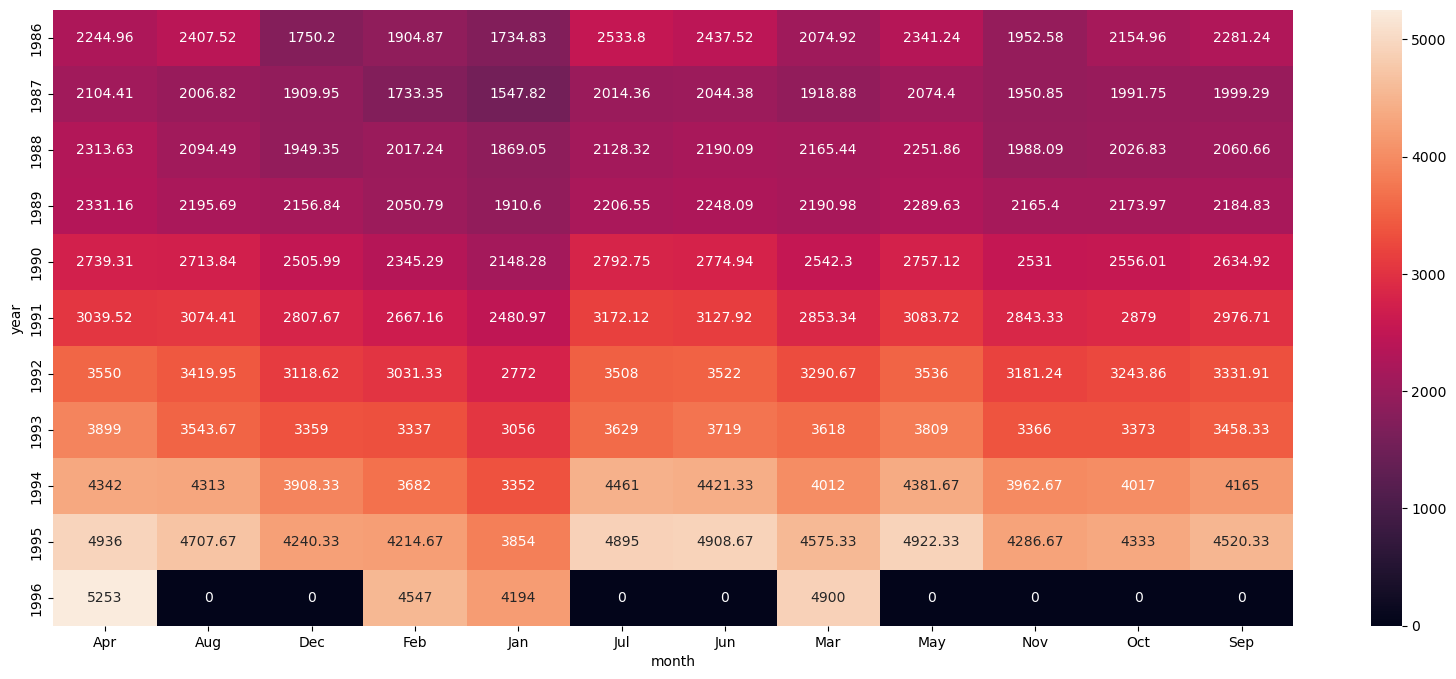

In [81]:
plt.figure(figsize=(20,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

In [82]:
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

#### Using OLS model for regression analysis to forecast

In [83]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668942

In [84]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     397.1
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           3.03e-36
Time:                        13:03:56   Log-Likelihood:                -705.92
No. Observations:                 100   AIC:                             1416.
Df Residuals:                      98   BIC:                             1421.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1642.3384     57.309     28.658      0.000    1528.611    1756.065
t             19.6334      0.985     19.928      0.000      17.678      21.589
==============================================================================
Omnibus:                        7.535   Durbin-Watson:                   0.203
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.789
Skew:                           0.683   Prob(JB):                       0.0204
Kurtosis:                       2.929   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
#Exponential

Exp = smf.ols('log_sales~t',data=train_data).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test_data['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

530.326802509923

In [86]:
Exp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     406.5
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           1.20e-36
Time:                        13:03:56   Log-Likelihood:                 84.607
No. Observations:                 100   AIC:                            -165.2
Df Residuals:                      98   BIC:                            -160.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.4782      0.021    353.829      0.000       7.436       7.520
t              0.0073      0.000     20.162      0.000       0.007       0.008
==============================================================================
Omnibus:                        6.147   Durbin-Watson:                   0.225
Prob(Omnibus):                  0.046   Jarque-Bera (JB):                5.627
Skew:                           0.561   Prob(JB):                       0.0600
Kurtosis:                       3.301   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
#Quadratic 

Quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_Quad = pd.Series(Quad.predict(test_data[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

371.29418344986675

In [88]:
Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     325.2
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           9.85e-44
Time:                        13:03:56   Log-Likelihood:                -684.82
No. Observations:                 100   AIC:                             1376.
Df Residuals:                      97   BIC:                             1383.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2022.9480     70.858     28.549      0.000    1882.314    2163.582
t             -2.7554      3.238     -0.851      0.397      -9.183       3.672
t_squared      0.2217      0.031      7.136      0.000       0.160       0.283
==============================================================================
Omnibus:                        3.492   Durbin-Watson:                   0.306
Prob(Omnibus):                  0.174   Jarque-Bera (JB):                2.371
Skew:                           0.193   Prob(JB):                        0.306
Kurtosis:                       2.352   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
#Additive seasonality 

add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483788

In [90]:
add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.6210
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.806
Time:                        13:03:56   Log-Likelihood:                -783.17
No. Observations:                 100   AIC:                             1590.
Df Residuals:                      88   BIC:                             1622.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2431.1678     60.077     40.467      0.000    2311.777    2550.559
Jan         -112.1065    208.114     -0.539      0.591    -525.689     301.476
Feb           98.7249    208.114      0.474      0.636    -314.858     512.308
Mar          309.5564    208.114      1.487      0.140    -104.026     723.139
Apr          520.3878    208.114      2.500      0.014     106.805     933.971
May          336.7034    219.714      1.532      0.129     -99.932     773.339
Jun          326.8245    219.714      1.488      0.140    -109.811     763.460
Jul          316.9457    219.714      1.443      0.153    -119.690     753.581
Aug          250.8819    219.714      1.142      0.257    -185.753     687.517
Sep          184.8182    219.714      0.841      0.403    -251.817     621.453
Oct          118.7544    219.714      0.540      0.590    -317.881     555.390
Nov           66.1439    219.714      0.301      0.764    -370.491     502.779
Dec           13.5333    219.714      0.062      0.951    -423.102     450.168
==============================================================================
Omnibus:                       30.612   Durbin-Watson:                   0.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.038
Skew:                           0.459   Prob(JB):                       0.0109
Kurtosis:                       1.848   Cond. No.                     1.01e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [91]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.80498810366447

In [92]:
add_sea_Quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     138.2
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           8.95e-52
Time:                        13:03:56   Log-Likelihood:                -632.59
No. Observations:                 100   AIC:                             1293.
Df Residuals:                      86   BIC:                             1330.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1865.7939     41.512     44.946      0.000    1783.271    1948.316
t             -2.9439      2.056     -1.432      0.156      -7.032       1.144
t_squared      0.2253      0.020     11.418      0.000       0.186       0.265
Jan         -159.7690     46.717     -3.420      0.001    -252.640     -66.898
Feb           31.7000     46.733      0.678      0.499     -61.202     124.602
Mar          222.7184     46.754      4.764      0.000     129.774     315.663
Apr          413.2862     46.781      8.834      0.000     320.288     506.284
May          372.3785     49.451      7.530      0.000     274.074     470.683
Jun          344.0384     49.465      6.955      0.000     245.706     442.371
Jul          315.2478     49.481      6.371      0.000     216.884     413.612
Aug          229.8216     49.499      4.643      0.000     131.421     328.222
Sep          143.9448     49.519      2.907      0.005      45.505     242.385
Oct           57.6174     49.541      1.163      0.248     -40.867     156.102
Nov          -15.7075     49.565     -0.317      0.752    -114.240      82.825
Dec          -89.4829     49.592     -1.804      0.075    -188.068       9.102
==============================================================================
Omnibus:                        0.473   Durbin-Watson:                   0.152
Prob(Omnibus):                  0.789   Jarque-Bera (JB):                0.611
Skew:                          -0.001   Prob(JB):                        0.737
Kurtosis:                       2.617   Cond. No.                     1.04e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.89e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [93]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test_data))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

1904.794417192032

In [94]:
Mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.6657
Date:                Wed, 23 Aug 2023   Prob (F-statistic):              0.767
Time:                        13:03:57   Log-Likelihood:                 6.6723
No. Observations:                 100   AIC:                             10.66
Df Residuals:                      88   BIC:                             41.92
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2447      0.022    324.766      0.000       7.200       7.289
Jan            0.4719      0.077      6.107      0.000       0.318       0.626
Feb            0.5592      0.077      7.236      0.000       0.406       0.713
Mar            0.6393      0.077      8.273      0.000       0.486       0.793
Apr            0.7134      0.077      9.232      0.000       0.560       0.867
May            0.6582      0.082      8.068      0.000       0.496       0.820
Jun            0.6547      0.082      8.025      0.000       0.493       0.817
Jul            0.6508      0.082      7.977      0.000       0.489       0.813
Aug            0.6277      0.082      7.694      0.000       0.466       0.790
Sep            0.6038      0.082      7.401      0.000       0.442       0.766
Oct            0.5791      0.082      7.098      0.000       0.417       0.741
Nov            0.5558      0.082      6.812      0.000       0.394       0.718
Dec            0.5309      0.082      6.508      0.000       0.369       0.693
==============================================================================
Omnibus:                       74.329   Durbin-Watson:                   0.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.756
Skew:                           0.261   Prob(JB):                       0.0125
Kurtosis:                       1.648   Cond. No.                     1.01e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [95]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_data))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

396.4197817382615

In [96]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     61.10
Date:                Wed, 23 Aug 2023   Prob (F-statistic):           4.29e-37
Time:                        13:03:57   Log-Likelihood:                 114.86
No. Observations:                 100   AIC:                            -203.7
Df Residuals:                      87   BIC:                            -169.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.9000      0.015    450.015      0.000       6.870       6.931
t              0.0074      0.000     25.888      0.000       0.007       0.008
Jan            0.4543      0.026     17.240      0.000       0.402       0.507
Feb            0.5342      0.026     20.263      0.000       0.482       0.587
Mar            0.6069      0.026     23.011      0.000       0.554       0.659
Apr            0.6736      0.026     25.526      0.000       0.621       0.726
May            0.6553      0.028     23.563      0.000       0.600       0.711
Jun            0.6445      0.028     23.171      0.000       0.589       0.700
Jul            0.6332      0.028     22.759      0.000       0.578       0.688
Aug            0.6027      0.028     21.656      0.000       0.547       0.658
Sep            0.5714      0.028     20.523      0.000       0.516       0.627
Oct            0.5392      0.028     19.360      0.000       0.484       0.595
Nov            0.5085      0.028     18.246      0.000       0.453       0.564
Dec            0.4763      0.028     17.077      0.000       0.421       0.532
==============================================================================
Omnibus:                       14.672   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.352
Skew:                           0.801   Prob(JB):                     0.000171
Kurtosis:                       4.264   Cond. No.                     7.99e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.3e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [97]:
data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_rmse

Models  RMSE_Values
0  rmse_add_sea_quad   225.804988
1          rmse_Quad   371.294183
2  rmse_Mult_add_sea   396.419782
3           rmse_Exp   530.326803
4        rmse_linear   686.874086
5       rmse_add_sea  1837.787972
6      rmse_Mult_sea  1904.794417

The OLS method is applied on different models and the RMSE values are tabulated as shown. Quadratic function with additive seasonality is giving the best RMSE value and hence is the best method to be used here.